In [1]:
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
# import torch

from utils.data import pickle_load, DimUniversalMinMaxScaler, DimUniversalStandardScaler, get_exchange_rate_dataset, get_ett_dataset, get_etl_dataset
from utils.metrics import MAE_numpy as MAE, MSE_numpy as MSE, MAPE_numpy as MAPE
# from utils.timediffusion import train_forecast


results_dir, data_dir = Path("results"), Path("data")
epochs, steps_per_epoch = 4, 16
horizons = [96, 192, 336, 720]
# get_lags = lambda h: h * 5 if h < 500 else h * 2
train_part = 0.7
test_size = 0.2
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

In [2]:
results = []
for horizon in horizons:
    results.append([])
    for ts_id in range(8):
        results[- 1].append(pickle_load(results_dir / f"Exchange/ts{ts_id}_horizon{horizon}.pkl"))

mm_scalers = []
s_scalers = []
for ts_id, ts in enumerate(get_exchange_rate_dataset(data_dir / "exchange_rate.txt")):
    ts = ts[:int(train_part * len(ts))]
    mm_scalers.append(DimUniversalMinMaxScaler())
    s_scalers.append(DimUniversalStandardScaler())
    mm_scalers[- 1].fit(ts)
    s_scalers[- 1].fit(ts)

mae=0.013415200910409292, mse=0.0002504013795110671
mae_snorm=0.13010106529059776, mse_snorm=0.023550705279107857
mae_mmnorm=0.027120413726221176, mse_mmnorm=0.0010233757371734167


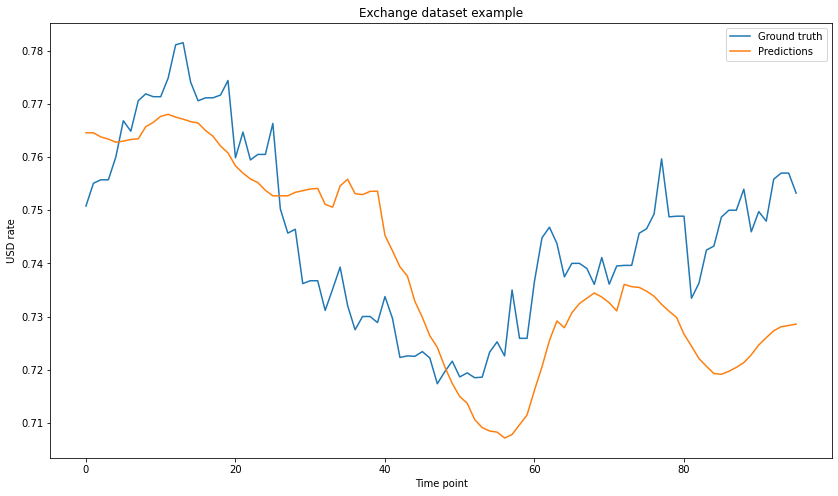

In [5]:
horizon_id = 0
ts_id = 0
sample_id = 3

y_true = results[horizon_id][ts_id]['y'][sample_id]
preds = results[horizon_id][ts_id]['preds'][sample_id]

mae = MAE(preds, y_true)
mse = MSE(preds, y_true)
print(f"{mae=}, {mse=}")

preds_snorm, y_true_snorm = map(s_scalers[ts_id].transform, (preds, y_true))
mae_snorm = MAE(preds_snorm, y_true_snorm)
mse_snorm = MSE(preds_snorm, y_true_snorm)
print(f"{mae_snorm=}, {mse_snorm=}")

preds_mmnorm, y_true_mmnorm = map(mm_scalers[ts_id].transform, (preds, y_true))
mae_mmnorm = MAE(preds_mmnorm, y_true_mmnorm)
mse_mmnorm = MSE(preds_mmnorm, y_true_mmnorm)
print(f"{mae_mmnorm=}, {mse_mmnorm=}")

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_true)
ax.plot(preds)
plt.xlabel("Time point")
plt.ylabel("USD rate")
plt.title("Exchange dataset example")
plt.legend(["Ground truth", "Predictions"])
plt.show()

In [4]:
preprocess_funcs_names = ["Pure", "StandardScaler", "MinMaxScaler"]
metrics = [MAE, MSE, MAPE]
result = []

for horizon_id, horizon in enumerate(horizons):
    ds_metrics = defaultdict(list)
    for ts_id in range(8):
        preprocess_funcs = [lambda x: x, s_scalers[ts_id].transform, mm_scalers[ts_id].transform]
        for pfunc, pfunc_name in zip(preprocess_funcs, preprocess_funcs_names):
            for mid, metric in enumerate(metrics):
                ds_metrics[f"{metric.__name__}_{pfunc_name}"].append(
                    metric(pfunc(results[horizon_id][ts_id]["preds"]), pfunc(results[horizon_id][ts_id]["y"]))
                    )
    ds_metrics = {key: np.mean(value) for key, value in ds_metrics.items()}
    result.append((ds_metrics["MAE_numpy_StandardScaler"], ds_metrics["MSE_numpy_StandardScaler"], horizon))

    print(f"{horizon=}")
    for pfunc_name in preprocess_funcs_names:
        print(f"\tMAE_{pfunc_name}={ds_metrics[f'MAE_numpy_{pfunc_name}']:0.3f} MSE_{pfunc_name}={ds_metrics[f'MSE_numpy_{pfunc_name}']:0.3f}")
    print(f"\tMAPE={ds_metrics['MAPE_numpy_Pure']}")

result = pd.DataFrame(result, columns=["mae", "mse", "horizon"])
res_path = Path(results_dir / "Exchange" / "TD_Exchange_norm.csv")
if not res_path.exists():
    result.to_csv(res_path, index=False)
result

horizon=96
	MAE_Pure=0.023 MSE_Pure=0.002
	MAE_StandardScaler=0.253 MSE_StandardScaler=0.130
	MAE_MinMaxScaler=0.056 MSE_MinMaxScaler=0.006
	MAPE=0.031103243081349506
horizon=192
	MAE_Pure=0.038 MSE_Pure=0.003
	MAE_StandardScaler=0.424 MSE_StandardScaler=0.313
	MAE_MinMaxScaler=0.094 MSE_MinMaxScaler=0.015
	MAPE=0.04971580418220564
horizon=336
	MAE_Pure=0.038 MSE_Pure=0.004
	MAE_StandardScaler=0.476 MSE_StandardScaler=0.458
	MAE_MinMaxScaler=0.103 MSE_MinMaxScaler=0.020
	MAPE=0.055301512046388696
horizon=720
	MAE_Pure=0.061 MSE_Pure=0.008
	MAE_StandardScaler=0.804 MSE_StandardScaler=1.122
	MAE_MinMaxScaler=0.173 MSE_MinMaxScaler=0.049
	MAPE=0.09420433691813945


,mae,mse,horizon
0,0.253010,0.129695,96
1,0.423549,0.313481,192
2,0.475845,0.458041,336
3,0.804342,1.121745,720


ETL

In [7]:
results = []
for horizon in horizons:
    results.append([])
    for ts_id in range(8):
        results[- 1].append(pickle_load(results_dir / f"ETL/ts{ts_id}_horizon{horizon}.pkl"))

mm_scalers = []
s_scalers = []
for ts_id, ts in enumerate(get_etl_dataset(data_dir / "LD2011_2014.txt")):
    ts = ts[:int(train_part * len(ts))]
    mm_scalers.append(DimUniversalMinMaxScaler())
    s_scalers.append(DimUniversalStandardScaler())
    mm_scalers[- 1].fit(ts)
    s_scalers[- 1].fit(ts)
    if ts_id == 64:
        break

c:\Users\Владислав\Учеба\Магистратура\time-series\project\utils\data.py:80: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, sep=";", usecols=[f"MT_{i:0>3}" for i in range(1, 371

mae=47.156694972325965, mse=5179.875361984909
mae_snorm=0.7242365589481373, mse_snorm=1.2217813248786948
mae_mmnorm=0.08802583406644841, mse_mmnorm=0.018048988740593228


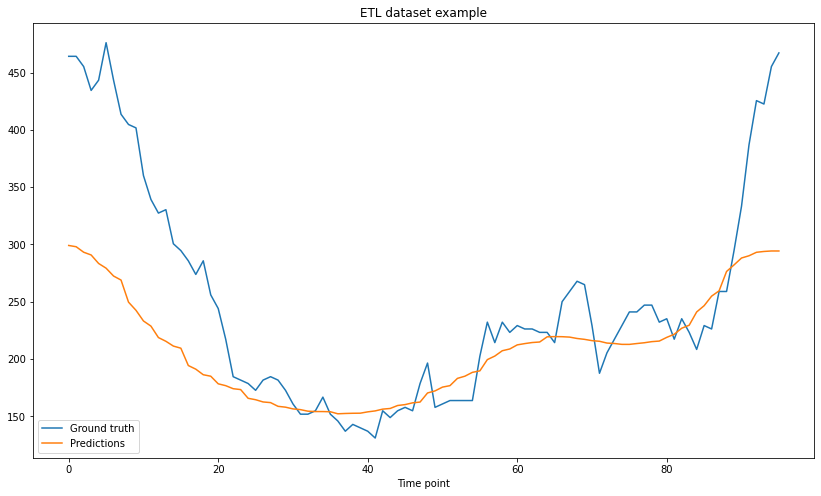

In [26]:
horizon_id = 0
ts_id = 5
sample_id = 0

# horizon_id = 0
# ts_id = 4
# sample_id = 1

# horizon_id = 0
# ts_id = 5
# sample_id = 1

y_true = results[horizon_id][ts_id]['y'][sample_id]
preds = results[horizon_id][ts_id]['preds'][sample_id]

mae = MAE(preds, y_true)
mse = MSE(preds, y_true)
print(f"{mae=}, {mse=}")

preds_snorm, y_true_snorm = map(s_scalers[ts_id].transform, (preds, y_true))
mae_snorm = MAE(preds_snorm, y_true_snorm)
mse_snorm = MSE(preds_snorm, y_true_snorm)
print(f"{mae_snorm=}, {mse_snorm=}")

preds_mmnorm, y_true_mmnorm = map(mm_scalers[ts_id].transform, (preds, y_true))
mae_mmnorm = MAE(preds_mmnorm, y_true_mmnorm)
mse_mmnorm = MSE(preds_mmnorm, y_true_mmnorm)
print(f"{mae_mmnorm=}, {mse_mmnorm=}")

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_true)
ax.plot(preds)
plt.xlabel("Time point")
plt.ylabel("")
plt.title("ETL dataset example")
plt.legend(["Ground truth", "Predictions"])
plt.show()

In [4]:
preprocess_funcs_names = ["Pure", "StandardScaler", "MinMaxScaler"]
metrics = [MAE, MSE, MAPE]
result = []

for horizon_id, horizon in enumerate(horizons):
    ds_metrics = defaultdict(list)
    for ts_id in range(8):
        preprocess_funcs = [lambda x: x, s_scalers[ts_id].transform, mm_scalers[ts_id].transform]
        for pfunc, pfunc_name in zip(preprocess_funcs, preprocess_funcs_names):
            for mid, metric in enumerate(metrics):
                ds_metrics[f"{metric.__name__}_{pfunc_name}"].append(
                    metric(pfunc(results[horizon_id][ts_id]["preds"]), pfunc(results[horizon_id][ts_id]["y"]))
                    )
    ds_metrics = {key: np.mean(value) for key, value in ds_metrics.items()}
    result.append((ds_metrics["MAE_numpy_StandardScaler"], ds_metrics["MSE_numpy_StandardScaler"], horizon))
    print(f"{horizon=}")
    for pfunc_name in preprocess_funcs_names:
        print(f"\tMAE_{pfunc_name}={ds_metrics[f'MAE_numpy_{pfunc_name}']:0.3f} MSE_{pfunc_name}={ds_metrics[f'MSE_numpy_{pfunc_name}']:0.3f}")
    print(f"\tMAPE={ds_metrics['MAPE_numpy_Pure']}")

result = pd.DataFrame(result, columns=["mae", "mse", "horizon"])
res_path = Path(results_dir / "ETL" / "TD_ETL_norm.csv")
if not res_path.exists():
    result.to_csv(res_path, index=False)
result

horizon=96
	MAE_Pure=21.825 MSE_Pure=1906.175
	MAE_StandardScaler=0.548 MSE_StandardScaler=0.790
	MAE_MinMaxScaler=0.064 MSE_MinMaxScaler=0.011
	MAPE=11375484.250944097
horizon=192
	MAE_Pure=23.043 MSE_Pure=1976.124
	MAE_StandardScaler=0.550 MSE_StandardScaler=0.806
	MAE_MinMaxScaler=0.065 MSE_MinMaxScaler=0.011
	MAPE=20002987.759533577
horizon=336
	MAE_Pure=26.283 MSE_Pure=2781.517
	MAE_StandardScaler=0.605 MSE_StandardScaler=0.996
	MAE_MinMaxScaler=0.071 MSE_MinMaxScaler=0.014
	MAPE=48748760.51262517
horizon=720
	MAE_Pure=23.081 MSE_Pure=2100.245
	MAE_StandardScaler=0.568 MSE_StandardScaler=0.793
	MAE_MinMaxScaler=0.064 MSE_MinMaxScaler=0.010
	MAPE=42022964.29385029


,mae,mse,horizon
0,0.547792,0.789512,96
1,0.549526,0.806474,192
2,0.605164,0.995776,336
3,0.567693,0.793440,720


ETT

In [2]:
results = []
for horizon in horizons:
    results.append([])
    for ts_id in range(7):
        results[- 1].append(pickle_load(results_dir / f"ETT/ts{ts_id}_horizon{horizon}.pkl"))

mm_scalers = []
s_scalers = []
for ts_id, ts in enumerate(get_ett_dataset(data_dir / "ETDataset")):
    ts = ts[:int(train_part * len(ts))]
    mm_scalers.append(DimUniversalMinMaxScaler())
    s_scalers.append(DimUniversalStandardScaler())
    mm_scalers[- 1].fit(ts)
    s_scalers[- 1].fit(ts)

mae=0.9501726826032003, mse=1.360661452912287
mae_snorm=0.23831778854338628, mse_snorm=0.08559687690932734
mae_mmnorm=0.028289058796891448, mse_mmnorm=0.0012060963484888992


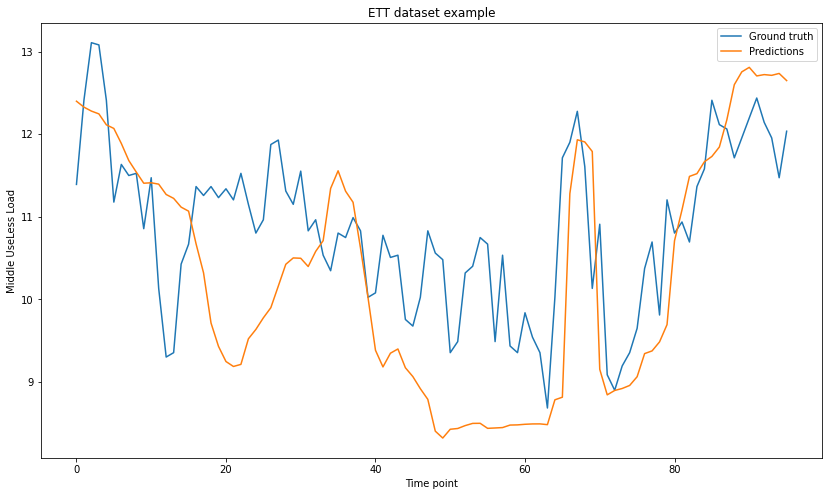

In [3]:
horizon_id = 0
ts_id = 3
sample_id = 0

# horizon_id = 1
# ts_id = 6
# sample_id = 0

y_true = results[horizon_id][ts_id]['y'][sample_id]
preds = results[horizon_id][ts_id]['preds'][sample_id]

mae = MAE(preds, y_true)
mse = MSE(preds, y_true)
print(f"{mae=}, {mse=}")

preds_snorm, y_true_snorm = map(s_scalers[ts_id].transform, (preds, y_true))
mae_snorm = MAE(preds_snorm, y_true_snorm)
mse_snorm = MSE(preds_snorm, y_true_snorm)
print(f"{mae_snorm=}, {mse_snorm=}")

preds_mmnorm, y_true_mmnorm = map(mm_scalers[ts_id].transform, (preds, y_true))
mae_mmnorm = MAE(preds_mmnorm, y_true_mmnorm)
mse_mmnorm = MSE(preds_mmnorm, y_true_mmnorm)
print(f"{mae_mmnorm=}, {mse_mmnorm=}")

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_true)
ax.plot(preds)
plt.xlabel("Time point")
plt.ylabel("Middle UseLess Load")
plt.title("ETT dataset example")
plt.legend(["Ground truth", "Predictions"])
plt.show()

In [10]:
preprocess_funcs_names = ["Pure", "StandardScaler", "MinMaxScaler"]
metrics = [MAE, MSE, MAPE]
result = []

for horizon_id, horizon in enumerate(horizons):
    ds_metrics = defaultdict(list)
    for ts_id in range(7):
        preprocess_funcs = [lambda x: x, s_scalers[ts_id].transform, mm_scalers[ts_id].transform]
        for pfunc, pfunc_name in zip(preprocess_funcs, preprocess_funcs_names):
            for mid, metric in enumerate(metrics):
                ds_metrics[f"{metric.__name__}_{pfunc_name}"].append(
                    metric(pfunc(results[horizon_id][ts_id]["preds"]), pfunc(results[horizon_id][ts_id]["y"]))
                    )
    ds_metrics = {key: np.mean(value) for key, value in ds_metrics.items()}
    result.append((ds_metrics["MAE_numpy_StandardScaler"], ds_metrics["MSE_numpy_StandardScaler"], horizon))
    print(f"{horizon=}")
    for pfunc_name in preprocess_funcs_names:
        print(f"\tMAE_{pfunc_name}={ds_metrics[f'MAE_numpy_{pfunc_name}']:0.3f} MSE_{pfunc_name}={ds_metrics[f'MSE_numpy_{pfunc_name}']:0.3f}")
    print(f"\tMAPE={ds_metrics['MAPE_numpy_Pure']}")

result = pd.DataFrame(result, columns=["mae", "mse", "horizon"])
res_path = Path(results_dir / "ETT" / "TD_ETT_norm.csv")
if not res_path.exists():
    result.to_csv(res_path, index=False)
result

horizon=96
	MAE_Pure=2.349 MSE_Pure=13.079
	MAE_StandardScaler=0.267 MSE_StandardScaler=0.136
	MAE_MinMaxScaler=0.038 MSE_MinMaxScaler=0.003
	MAPE=29894253.810119715
horizon=192
	MAE_Pure=2.631 MSE_Pure=15.554
	MAE_StandardScaler=0.306 MSE_StandardScaler=0.174
	MAE_MinMaxScaler=0.043 MSE_MinMaxScaler=0.004
	MAPE=15987035.116811205
horizon=336
	MAE_Pure=2.630 MSE_Pure=16.124
	MAE_StandardScaler=0.302 MSE_StandardScaler=0.174
	MAE_MinMaxScaler=0.043 MSE_MinMaxScaler=0.004
	MAPE=10805359.028182968
horizon=720
	MAE_Pure=2.968 MSE_Pure=19.903
	MAE_StandardScaler=0.331 MSE_StandardScaler=0.206
	MAE_MinMaxScaler=0.047 MSE_MinMaxScaler=0.004
	MAPE=26003029.554788586


,mae,mse,horizon
0,0.267422,0.136090,96
1,0.306447,0.174042,192
2,0.301698,0.174115,336
3,0.331348,0.206180,720
